# Requirements

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [2]:
df = pd.read_csv('data/climate-data.csv')

In [3]:
df.shape

(1462, 5)

In [4]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
df["date"] = pd.to_datetime(df["date"])
df.set_index(keys=["date"], inplace=True)
df.sort_index(inplace=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


Explore the dataset using visualizations of your choice.

<Axes: >

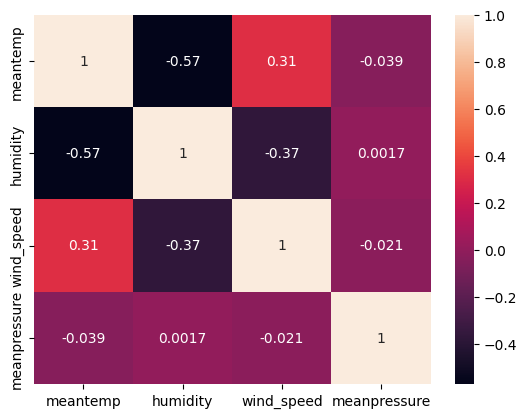

In [6]:
sns.heatmap(df.corr(), annot=True)

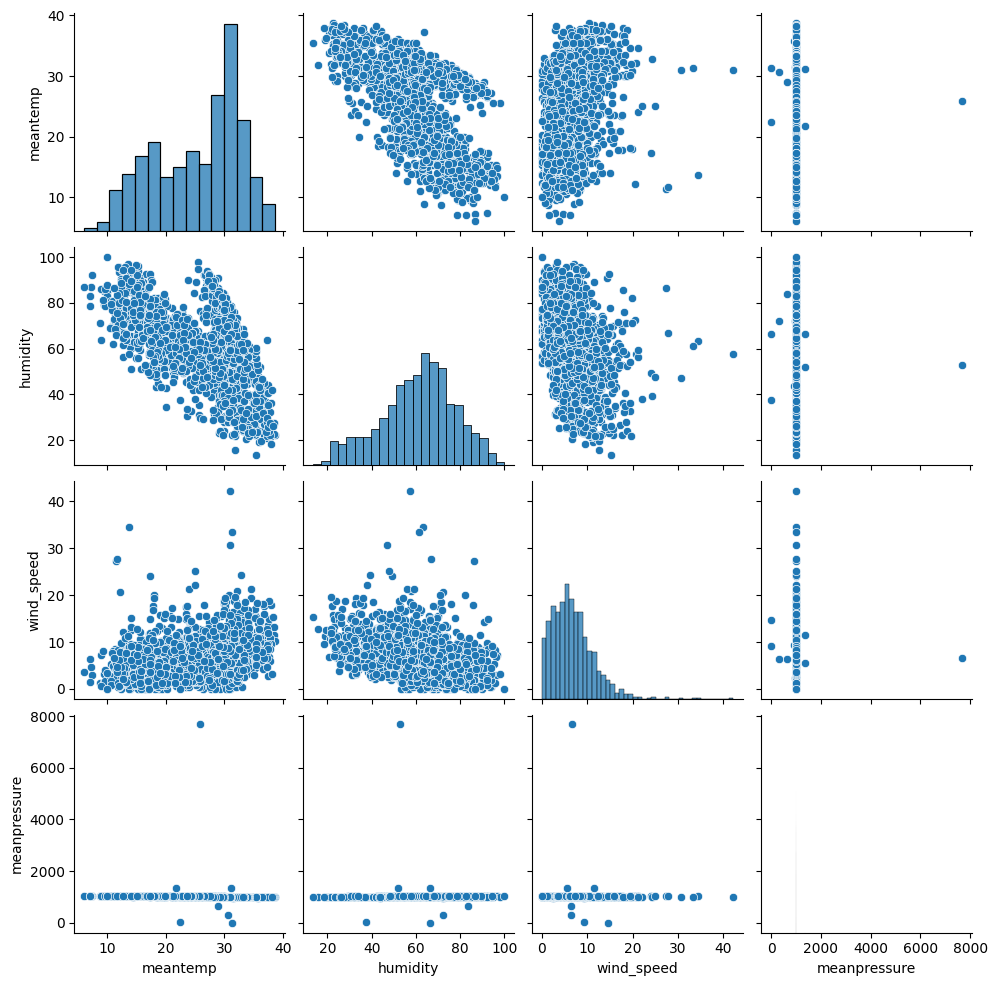

In [7]:
sns.pairplot(df)

<Axes: xlabel='date', ylabel='meantemp'>

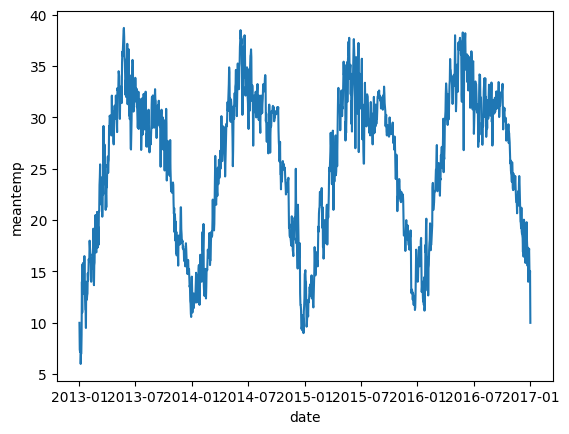

In [8]:
sns.lineplot(df["meantemp"])

<Axes: xlabel='date', ylabel='humidity'>

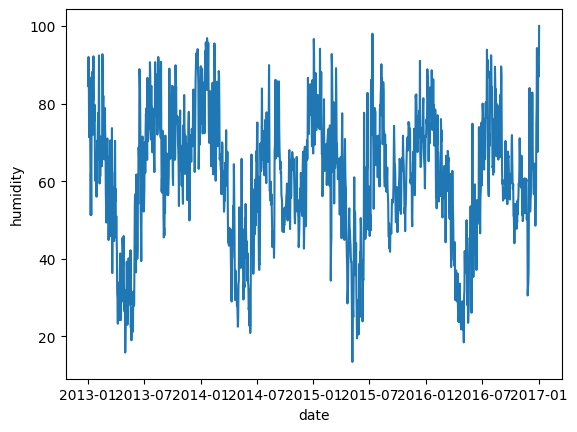

In [9]:
sns.lineplot(df["humidity"])

<Axes: xlabel='date', ylabel='wind_speed'>

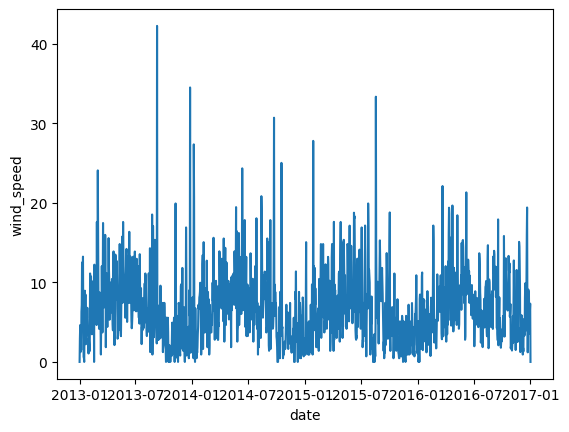

In [10]:
sns.lineplot(df["wind_speed"])

<Axes: xlabel='date', ylabel='meanpressure'>

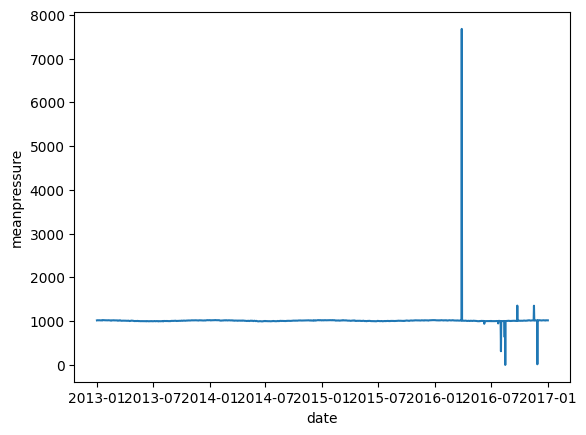

In [11]:
sns.lineplot(df["meanpressure"])

# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [12]:
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [13]:
features = ["humidity", "wind_speed", "meanpressure"]
target = "meantemp"

In [14]:
lags = range(3, 0, -1)
list(lags)

[3, 2, 1]

In [15]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df.head()

,meantemp,humidity,wind_speed,meanpressure,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
date,,,,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.500000,0.000000,1015.666667,10.000000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,NaN,NaN,NaN,NaN,84.5,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000
2013-01-04,8.666667,71.333333,1.233333,1017.166667,84.5,0.00,1015.666667,10.0,92.0,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,92.0,2.98,1017.800000,7.4,87.0,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667


In [16]:
df.drop(columns=features, inplace=True)
df.dropna(axis=0, inplace=True)
df.head()

,meantemp,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
date,,,,,,,,,,,,,
2013-01-04,8.666667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
2013-01-06,7.000000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000
2013-01-07,7.000000,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000
2013-01-08,8.857143,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000,7.000000


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [17]:
X, y = df.drop(columns=[target]), df[target]

In [18]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

In [19]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [20]:
scaler = MinMaxScaler()
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

In [21]:
lag = 3
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(1167, 3, 4)

In [22]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))

### LSTM

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [73]:
model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(4, activation="relu", return_sequences=True),
    LSTM(2, activation="relu"),
    Dense(1, activation="linear")
])

In [74]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 3, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 2)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203 (812.00 B)

 Trainable params: 203 (812.00 B)

 Non-trainable params: 0 (0.00 B)

In [75]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [76]:
history = model.fit(train_X, train_y, validation_split=0.20, epochs=6, batch_size=8, shuffle=False)

Epoch 1/6
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2922 - mean_squared_error: 0.2922 - val_loss: 0.1223 - val_mean_squared_error: 0.1223
Epoch 2/6
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1064 - mean_squared_error: 0.1064 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 3/6
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 4/6
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 5/6
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/6
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0038 - val_mean_squared_error: 0.0038


<Axes: >

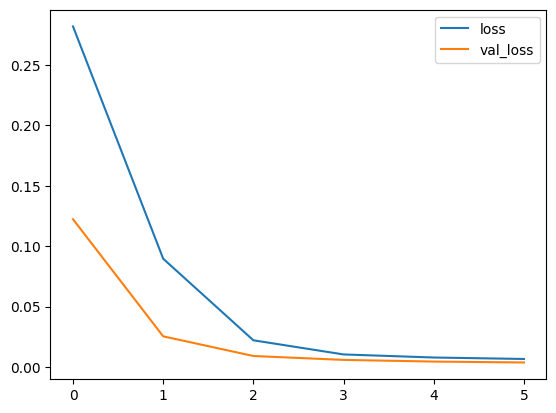

In [77]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [78]:
pred_y = model.predict(test_X)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [79]:
pred_y = scaler.inverse_transform(pred_y)

In [80]:
mean_absolute_error(test_y, pred_y)

2.226464008631278

In [81]:
mean_squared_error(test_y, pred_y)

14.573009308511795

In [82]:
r2_score(test_y, pred_y)

0.5450416762413011